In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel
from tqdm import tqdm
import warnings
from sklearn.exceptions import ConvergenceWarning
import random

def extract_explosive_segment(times, fluxes, flux_errs, gap_threshold=50):
    """
    将给定序列按时间 gap 分段，并返回标准差最大的 segment。

    参数：
        times: array-like, MJD 序列
        fluxes: array-like, flux
        flux_errs: array-like, flux_err
        gap_threshold: float, 相邻点判定为 gap 的时间阈值

    返回：
        times_segment, fluxes_segment, flux_errs_segment
    """
    if len(times) < 2:
        return None, None, None, None, None

    # 按时间排序
    idx_sort = np.argsort(times)
    times = times[idx_sort]
    fluxes = fluxes[idx_sort]
    flux_errs = flux_errs[idx_sort]

    # gap 分段
    diffs = np.diff(times)
    break_points = np.where(diffs > gap_threshold)[0] + 1
    segments = []
    prev = 0
    for bp in break_points:
        segments.append((times[prev:bp], fluxes[prev:bp], flux_errs[prev:bp]))
        prev = bp
    segments.append((times[prev:], fluxes[prev:], flux_errs[prev:]))

    if not segments:
        return None, None, None, None, None

    # 找出 std 最大的段
    best_segment = max(segments, key=lambda seg: np.std(seg[1]) if len(seg[1]) > 1 else 0)
    t_seg, f_seg, e_seg = best_segment
    return t_seg, f_seg, e_seg

# === 配置路径 ===
csv_file = 'filtered_explosive_sources.csv'
base_dir = 'ZTF_SN_FLUX'
band_list = ['g', 'r']
target_length = 100
before_peak_days = 20
after_peak_days = 80

df = pd.read_csv(csv_file)

# === 随机种子 ===
random.seed(42)
np.random.seed(42)


# === 存储插值结果以及标签 ===
interpolated_data = {band: [] for band in band_list}
mask_data = {band: [] for band in band_list}
mergedType = []  # 存储 mergedType
time_grid = np.linspace(-before_peak_days, after_peak_days, target_length)

# === 可视化样本容器 ===
visualize_samples = []

# === 插值处理 ===
for _, row in tqdm(df.iterrows(), total=len(df)):
    sid = row['SourceID']
    one_sample = {}
    success = True  # 是否跳过样本的标志

    for band in band_list:
        file_path = os.path.join(base_dir, sid, f'{sid}_{band}.csv')
        if not os.path.exists(file_path):
            success = False
            break

        try:
            data = pd.read_csv(file_path).dropna()
            times = data.iloc[:, 0].values
            fluxes = data.iloc[:, 1].values
            flux_err = data.iloc[:, 2].astype(float).values
            rbs = data.iloc[:, 3].astype(float).values
            snr = fluxes / flux_err
            mask = (snr >= 3) & (rbs >= 0.4)
            times, fluxes, flux_err = times[mask], fluxes[mask], flux_err[mask]
            times, fluxes, flux_err = extract_explosive_segment(times, fluxes, flux_err)

            peak_idx = np.argmax(fluxes)
            t_peak = times[peak_idx]
            t_min, t_max = np.min(times), np.max(times)

            absolute_time_grid = time_grid + t_peak
            gp_mask = (absolute_time_grid >= t_min) & (absolute_time_grid <= t_max)
            final_mask = gp_mask.astype(int)

            with warnings.catch_warnings():
                warnings.simplefilter("ignore", ConvergenceWarning)
                kernel = ConstantKernel(1.0) * RBF(length_scale=10.0) + WhiteKernel(noise_level=1.0)
                gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-2, normalize_y=True)
                gp.fit(times.reshape(-1, 1), fluxes)
                flux_pred, _ = gp.predict(absolute_time_grid.reshape(-1, 1), return_std=True)

            flux_pred[~gp_mask] = 0.0

            interpolated_data[band].append(flux_pred)
            mask_data[band].append(final_mask)

            one_sample[band] = {
                'times': times,
                'fluxes': fluxes,
                'interpolated': flux_pred,
                'mask': final_mask,
                't_peak': t_peak,
                'absolute_grid': absolute_time_grid
            }

        except Exception as e:
            print(f"Error processing {file_path}: {e}")
            success = False
            break

    if success:
        # === 加载 label.txt 读取 MergedType ===
        label_path = os.path.join(base_dir, sid, 'label.txt')
        if not os.path.exists(label_path):
            continue  # 没有 label 就跳过

        with open(label_path, 'r') as f:
            lines = f.readlines()

        merged_type = None
        for line in lines:
            if line.startswith('MergedType:'):
                merged_type = line.split(':')[1].strip()
                break

        if merged_type is None:
            continue  # 没有读取到 MergedType

        mergedType.append(merged_type)

        if len(visualize_samples) < 10:
            visualize_samples.append(one_sample)


100%|██████████| 6220/6220 [02:41<00:00, 38.44it/s]


In [31]:
import numpy as np

def convert_ndarray_to_list(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {k: convert_ndarray_to_list(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_ndarray_to_list(v) for v in obj]
    elif isinstance(obj, tuple):
        return tuple(convert_ndarray_to_list(v) for v in obj)
    else:
        return obj


combined = {
    "interpolated_data": interpolated_data,
    "mask_data": mask_data,
    "mergedType": mergedType
}

cleaned = convert_ndarray_to_list(combined)

import json
with open("combined_data.json", "w") as f:
    json.dump(cleaned, f, indent=2)

In [5]:
import pywt

# 选择小波基函数和变换层数
wavelet = 'db4'          # 常用的小波，如 'db4', 'sym5'
max_level = pywt.dwt_max_level(data_len=100, filter_len=pywt.Wavelet(wavelet).dec_len)

# 用于保存所有小波特征
wavelet_features = []

# 对插值后的 g/r flux 执行小波变换
for i in range(len(interpolated_data['g'])):
    g_flux = interpolated_data['g'][i]
    r_flux = interpolated_data['r'][i]
    g_coeffs = pywt.wavedec(g_flux, wavelet=wavelet, level=max_level)
    r_coeffs = pywt.wavedec(r_flux, wavelet=wavelet, level=max_level)

    # for i, c in enumerate(g_coeffs):
    #     print(f"Level {len(g_coeffs)-i-1 if i > 0 else 'A'}: length = {len(c)}")

    # 将多层小波系数 flatten 成一维向量
    g_feat = np.concatenate(g_coeffs)
    r_feat = np.concatenate(r_coeffs)

    combined_feature = np.concatenate([g_feat, r_feat])  # shape: [n_features]
    wavelet_features.append({
        'feature': combined_feature,
        'g_mask': mask_data['g'][i],
        'r_mask': mask_data['r'][i]
    })


In [6]:
print(len(wavelet_features[3]['feature']))

238


维度数（95%解释方差）：3
维度数（99%解释方差）：9


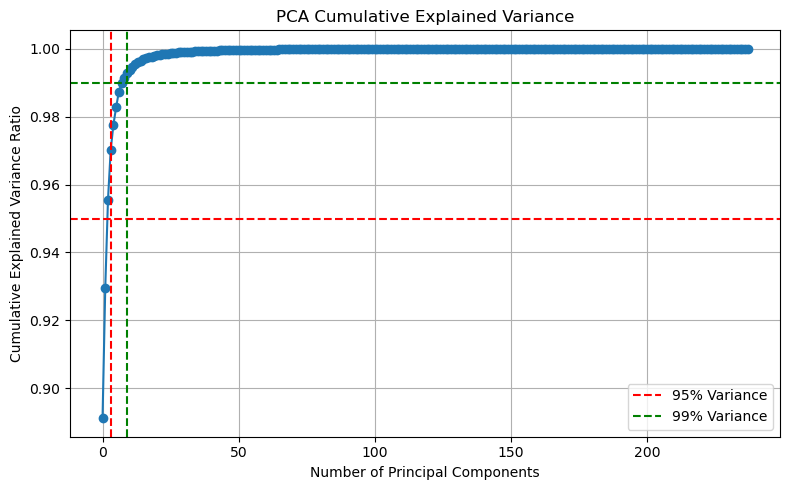

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import joblib  # 如果你想保存PCA模型

# 假设你的小波特征为 shape=(N_samples, 238)
# wavelet_features = [{'feature': ...}, ...]
X_wavelet = np.array([item['feature'] for item in wavelet_features])

# === 拟合 PCA ===
pca = PCA()
X_pca_all = pca.fit_transform(X_wavelet)

# === 累计解释方差比 ===
cumsum_var = np.cumsum(pca.explained_variance_ratio_)

# === 找到95%、99%的维度数 ===
dim_95 = np.argmax(cumsum_var >= 0.95) + 1
dim_99 = np.argmax(cumsum_var >= 0.99) + 1
print(f"维度数（95%解释方差）：{dim_95}")
print(f"维度数（99%解释方差）：{dim_99}")

# === 可视化 ===
plt.figure(figsize=(8, 5))
plt.plot(cumsum_var, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
plt.axhline(y=0.99, color='g', linestyle='--', label='99% Variance')
plt.axvline(x=dim_95, color='r', linestyle='--')
plt.axvline(x=dim_99, color='g', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('PCA Cumulative Explained Variance')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [258]:
import torch
from torch.utils.data import Dataset

class SupernovaPCADataset(Dataset):
    def __init__(self, features, labels):
        self.label_mapping = {'Ia': 0, 'II': 1, 'Ibc': 2, 'Other': 3}
        # self.label_mapping = {'Ia': 0, 'II': 1, 'Ibc': 1, 'Other': 1}
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor([self.label_mapping[l] for l in labels], dtype=torch.long)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

    def get_label_mapping(self):
        return self.label_mapping


In [259]:
# 假设你已经得到如下变量：
# wavelet_features_pca: List[np.array shape (8,)]
# wavelet_labels: List[str]
from sklearn.preprocessing import StandardScaler

# === 对 PCA 降维后的特征做标准化 ===
X_pca = X_pca_all[:, :9] 
scaler = StandardScaler()
X_pca_scaled = scaler.fit_transform(X_pca)  # shape: (N_samples, 8)


dataset = SupernovaPCADataset(X_pca_scaled, mergedType)

# 例如构建 DataLoader
from torch.utils.data import random_split, DataLoader

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64)

In [271]:
# 假设你有 dataset (就是之前定义的那个SupernovaDataset)
# 统计所有label
all_labels = []
for i in range(len(dataset)):
    _, label = dataset[i]
    all_labels.append(label.item())

all_labels = np.array(all_labels)
classes, counts = np.unique(all_labels, return_counts=True)

# 打印一下每类数量
print("Class counts:", dict(zip(classes, counts)))

# 计算权重
total_samples = len(all_labels)
class_weights = total_samples / (len(classes) * counts)  # 标准公式

class_weights = np.clip(class_weights, 0.5, 10.0)  # 最小1.0，最大5.0
class_weights = torch.tensor(class_weights, dtype=torch.float32)
# 转为torch tensor

print("Class weights:", class_weights)

Class counts: {np.int64(0): np.int64(4755), np.int64(1): np.int64(1126), np.int64(2): np.int64(291), np.int64(3): np.int64(48)}
Class weights: tensor([ 0.5000,  1.3810,  5.3436, 10.0000])


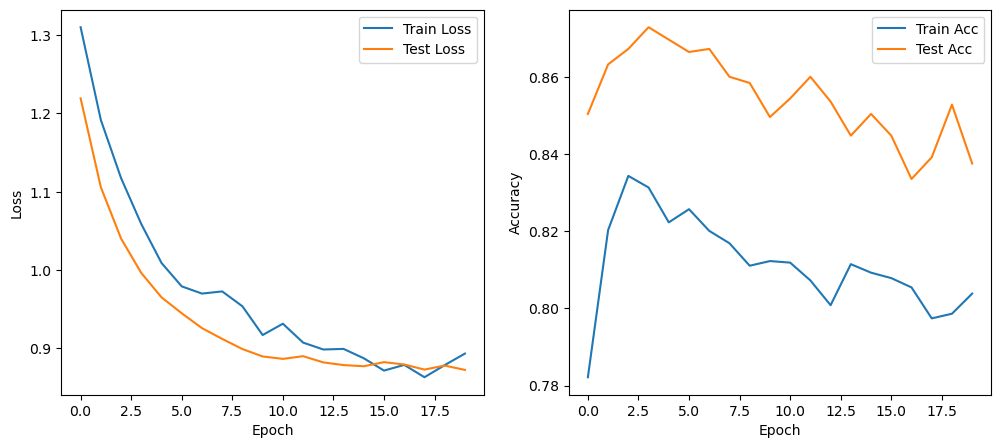

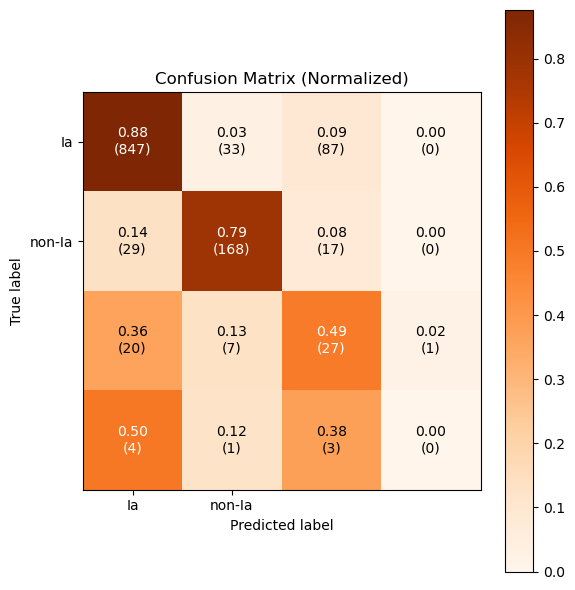

In [272]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# === 构建简单的 MLP 模型 ===
model = nn.Sequential(
    nn.Linear(9, 64),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Dropout(0.3),
    # nn.Linear(32, 4)  # 假设 4 类
    # nn.Linear(32, 2)  # 假设 2 类
    nn.Linear(32, counts.shape[0])  # 假设 4 类

)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# === 训练参数 ===
num_epochs = 20
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
best_accuracy = 0.0
best_model_state = None  # ===> 用于保存最优模型参数

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_losses.append(running_loss / total)
    train_accuracies.append(correct / total)

    model.eval()
    test_loss, correct, total = 0.0, 0, 0


    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            probs = torch.softmax(outputs, dim=1)  # ← 加 softmax 得到 y_prob
            _, predicted = torch.max(probs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            # all_labels.extend(labels.cpu().numpy())
            # all_preds.extend(predicted.cpu().numpy())
            # all_probs.extend(probs.cpu().numpy())

    test_losses.append(test_loss / total)
    test_acc = correct / total
    test_accuracies.append(test_acc)

    # ===> 如果是最优模型，就保存其 state_dict
    if test_acc > best_accuracy:
        best_accuracy = test_acc
        best_model_state = model.state_dict()


all_labels, all_preds, all_probs = [], [], []
model.load_state_dict(best_model_state)
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)  # ← 加 softmax 得到 y_prob
        _, predicted = torch.max(probs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# === 可视化 Loss 和 Accuracy ===
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(test_accuracies, label='Test Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# === 混淆矩阵 ===
cm = confusion_matrix(all_labels, all_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)

# 可视化
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Oranges)
plt.colorbar(im, ax=ax)

# 设置标签
# classes = ['Ia', 'II', 'Ibc', 'Other']  # 自定义类别名称
classes = ['Ia', 'non-Ia']  # 自定义类别名称
ax.set(
    xticks=np.arange(len(classes)),
    yticks=np.arange(len(classes)),
    xticklabels=classes,
    yticklabels=classes,
    ylabel='True label',
    xlabel='Predicted label',
    title='Confusion Matrix (Normalized)'
)

# 显示数值 + 真实数量
thresh = cm_normalized.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        value = cm_normalized[i, j]
        count = cm[i, j]
        ax.text(j, i, f'{value:.2f}\n({count})',
                ha="center", va="center",
                color="white" if value > thresh else "black")

plt.tight_layout()
plt.show()
# # 假设 cm, all_labels, all_preds 已定义
# cm = confusion_matrix(all_labels, all_preds)
# cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# fig, ax = plt.subplots(figsize=(6, 6))
# disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized)
# disp.plot(cmap=plt.cm.Oranges, values_format=".2f", ax=ax)

# # 添加原始数量（避免重合，y+0.25 表示向下偏移）
# for (i, j), val in np.ndenumerate(cm):
#     ax.text(j, i + 0.25, f"({val})", ha='center', va='top', color='black', fontsize=9)

# plt.title("Confusion Matrix (Normalized + Count)")
# plt.tight_layout()
# plt.show()



Macro F1 Score: 0.4968
Weighted AUC Score: 0.9145


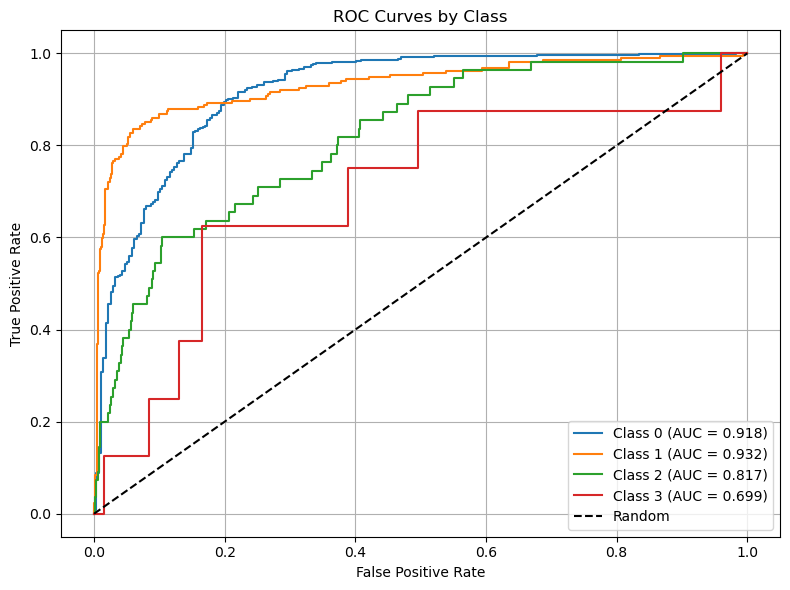

In [273]:
from sklearn.metrics import roc_curve, auc, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize
# from scipy.special import softmax  # 若输出为logits则手动加

y_true = np.array(all_labels)
y_pred = np.array(all_preds)
y_prob = np.array(all_probs)
num_classes = y_prob.shape[1]

# 二分类则用 binary方式
if num_classes == 2:
    fpr, tpr, _ = roc_curve(y_true, y_prob[:, 1])
    auc_val = auc(fpr, tpr)
    f1 = f1_score(y_true, y_pred)
    
    print(f"\nF1 Score: {f1:.4f}")
    print(f"AUC Score: {auc_val:.4f}")
    
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {auc_val:.3f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

else:
    # 多分类处理
    y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))
    f1 = f1_score(y_true, y_pred, average='macro')
    # auc_val = roc_auc_score(y_true_bin, y_prob, average='macro')
    auc_val = roc_auc_score(y_true_bin, y_prob, average='weighted')
    print(f"\nMacro F1 Score: {f1:.4f}")
    print(f"Weighted AUC Score: {auc_val:.4f}")

    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
        auc_i = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Class {i} (AUC = {auc_i:.3f})")
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves by Class")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [267]:
import numpy as np

def convert_to_json_serializable(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, (np.int64, np.int32, np.integer)):
        return int(obj)
    elif isinstance(obj, (np.float64, np.float32, np.floating)):
        return float(obj)
    elif isinstance(obj, dict):
        return {k: convert_to_json_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_json_serializable(v) for v in obj]
    else:
        return obj

Comb = {
    "all-labels": all_labels,
    "all-preds": all_preds,
    "all-probs": all_probs,
}

with open("four-class_wavelet+PCA+mlp.json", "w") as f:
    json.dump(convert_to_json_serializable(Comb), f, indent=2)